<a href="https://colab.research.google.com/github/oscisn93/fruit-inspection/blob/main/Fruit_Inspection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis of Fruit Inspection Dataset

In [ ]:
# Install Dependencies and Setup
!pip install kaggle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as image
import os

Make sure to set up Kaggle Credentials: \\
"Create New API Token" \\
You will download a kaggle.json \\

In [ ]:
# Upload Kaggle API Key to Colab
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
# Move the key to the right location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Set up and get dataset
# https://www.kaggle.com/datasets/shashwatwork/fruitnet-indian-fruits-dataset-with-quality/data

!kaggle datasets download -d shashwatwork/fruitnet-indian-fruits-dataset-with-quality

100% 3.03G/3.03G [00:17<00:00, 226MB/s]
100% 3.03G/3.03G [00:17<00:00, 188MB/s]


In [ ]:
!unzip -q /content/fruitnet-indian-fruits-dataset-with-quality.zip -d /content/dataset

In [ ]:
import os


image_set = {}
filenames = os.listdir('/content/dataset/Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good')


for filename in filenames:
  image_nums = filename.split('_')
  image_nums[-1] = image_nums[-1].split('.')[0]

  print(image_nums)

  if len(image_nums) < 3:
    image_set['_'.join(image_nums)] = []
  elif len(image_nums) > 2:
    image_set['_'.join(image_nums[:2])] = [image_nums[-1]]
  else:
    continue

print(len(filenames))
print(len(image_set))


Streaming output truncated to the last 5000 lines.
['20190820', '152421']
['20190820', '154523']
['20190820', '151648', '24793']
['20190820', '152637', '25046']
['20190820', '154336', '26514']
['20190820', '152659', '25096']
['20190820', '151556']
['IMG20200728182302', '27597']
['20190820', '143818', '23033']
['20190820', '150129', '23996']
['20190820', '151043', '24479']
['20190820', '153703']
['20190820', '151342', '24576']
['20190820', '144614', '23304']
['IMG20200728182156', '01', '27515']
['20190820', '151118', '24525']
['20190820', '153110', '25453']
['20190820', '151534', '24711']
['20190820', '154535', '26607']
['20190820', '154123', '26296']
['20190820', '153729', '26011']
['20190820', '152745', '25172']
['20190820', '144636', '23337']
['20190820', '144211', '23171']
['20190820', '153456', '25823']
['20190820', '150642', '24260']
['20190820', '154559', '26647']
['20190820', '153852']
['20190820', '150044', '23902']
['20190820', '151131']
['20190820', '154825', '26868']
['20190

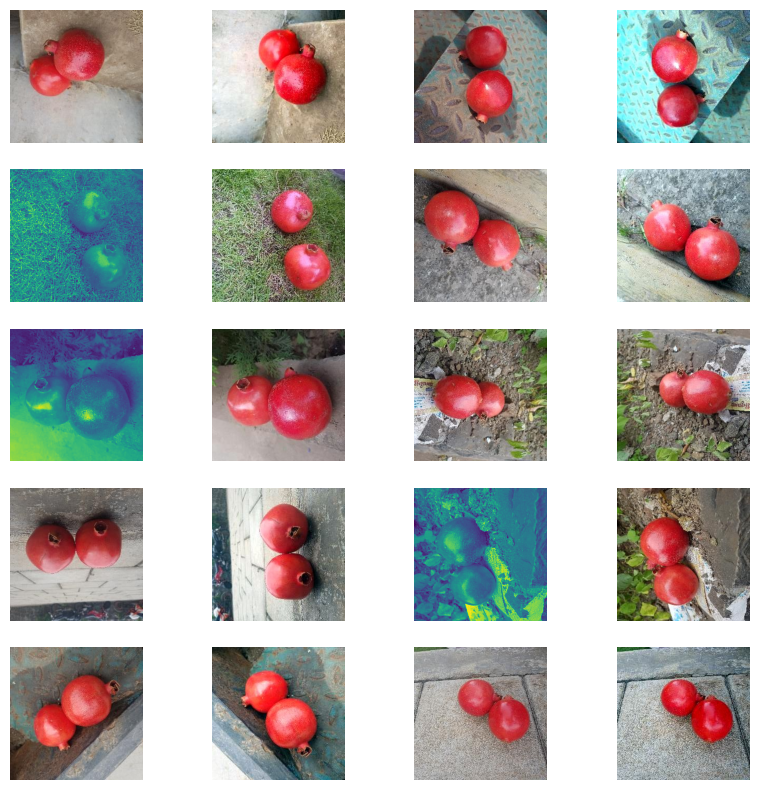

In [ ]:
import random


dataset_path = "/content/dataset/Processed Images_Fruits"
pomagranate_good_path = "/Good Quality_Fruits/Pomegranate_Good"
os.chdir(dataset_path+pomagranate_good_path)


duplicate_images = []

for key, value in image_set.items():
  if len(value) >= 1:
    duplicate_images.extend([f'{key}_{item}' for item in value])
    duplicate_images.append(key)


random_images = duplicate_images[:20]


plt.figure(figsize=(10, 10))
for i, filename in enumerate(random_images):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image.imread(f"{filename}.jpg"))
    plt.axis("off")


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
batch_size = 64
img_height = 180
img_width = 180


train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 19526 files belonging to 3 classes.
Using 15621 files for training.
Found 19526 files belonging to 3 classes.
Using 3905 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bad Quality_Fruits', 'Good Quality_Fruits', 'Mixed Qualit_Fruits']


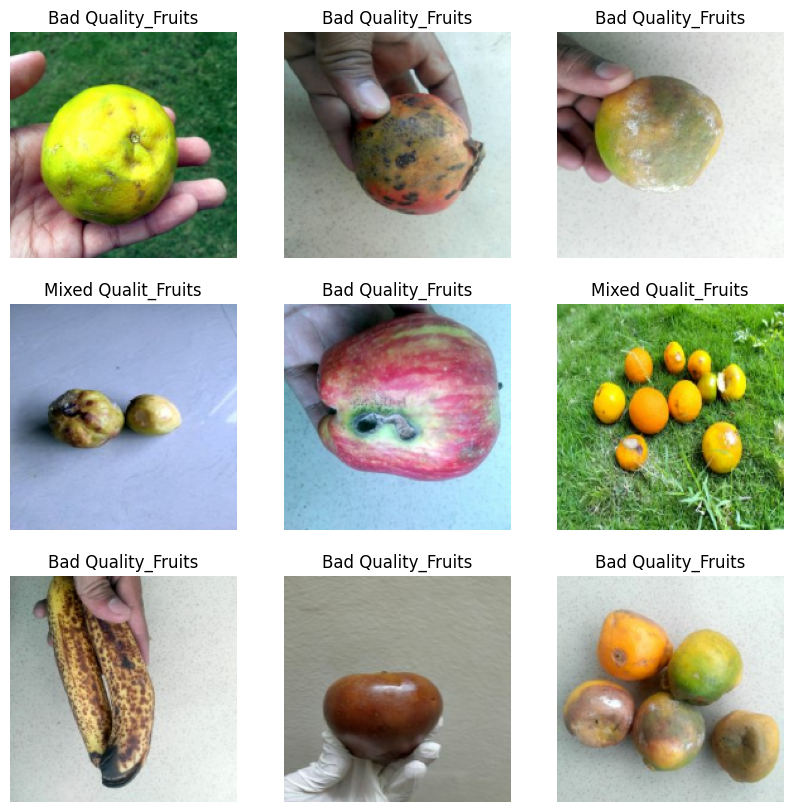

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
  ]
)

model = tf.keras.models.Sequential([
    # data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names))
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/5
245/245 [==============================] - 97s 388ms/step - loss: 0.3788 - accuracy: 0.8512 - val_loss: 0.2558 - val_accuracy: 0.9050
Epoch 2/5
245/245 [==============================] - 94s 377ms/step - loss: 0.2168 - accuracy: 0.9190 - val_loss: 0.1809 - val_accuracy: 0.9347
Epoch 3/5
245/245 [==============================] - 93s 376ms/step - loss: 0.1634 - accuracy: 0.9405 - val_loss: 0.1433 - val_accuracy: 0.9524
Epoch 4/5
245/245 [==============================] - 96s 386ms/step - loss: 0.1285 - accuracy: 0.9524 - val_loss: 0.1274 - val_accuracy: 0.9554
Epoch 5/5
245/245 [==============================] - 93s 374ms/step - loss: 0.1108 - accuracy: 0.9584 - val_loss: 0.1156 - val_accuracy: 0.9593


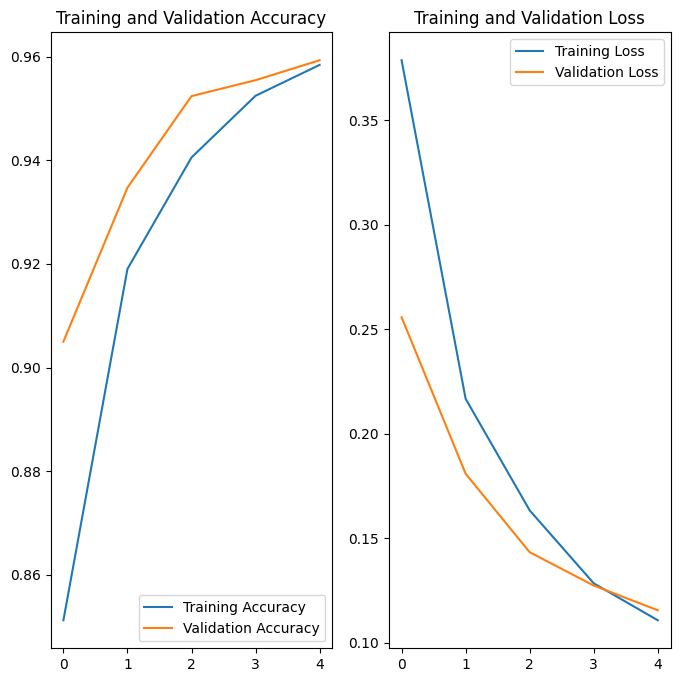

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.65),
    tf.keras.layers.RandomZoom(0.05),
  ]
)

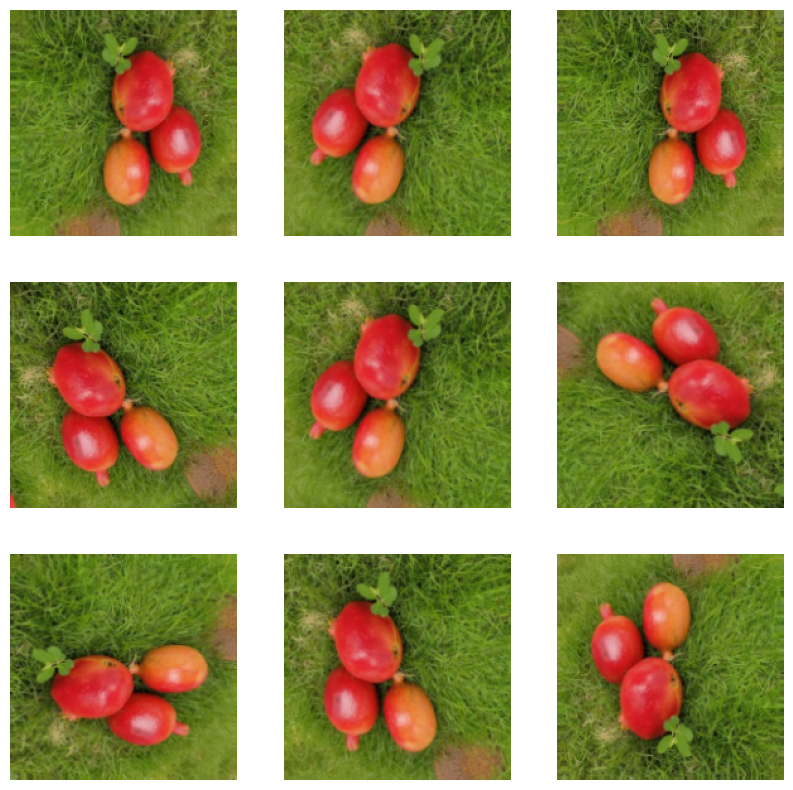

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
